### Exercises

#### Question 1

Alongside this notebook is a file `daily_quotes.csv` (the same one that we used for the Pandas exercises).

Using this data write a function that generates a composite of line charts (2 columns wide), that charts the closing price for each symbol in the data.

### Question 2

Expand on your previous function to include an `n`-day moving average on each chart. (When you calculate the moving average, be careful with the order of the data in each subset of data).

#### Question 3

Using the previous charts, add horizontal lines for the 25th, 50th and 75th percentiles of the close price (calculated over the entire time period).

## Setup

We'll use Pandas for data wrangling and Matplotlib for plotting.

In [1]:
from __future__ import annotations

from dataclasses import dataclass
from math import ceil
from pathlib import Path
from typing import Iterable, Optional, Sequence, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Data loading / cleaning helpers

The provided CSV has slightly unusual column names (e.g., ` Close/Last`) and may include a UTF-8 BOM. We'll normalize column names and ensure numeric/date parsing is robust.

In [2]:
@dataclass(frozen=True)
class DailyQuotesSchema:
    symbol: str = "Symbol"
    date: str = "Date"
    close: str = "Close/Last"
    volume: str = "Volume"
    open_: str = "Open"
    high: str = "High"
    low: str = "Low"


def _normalize_columns(cols: Iterable[str]) -> list[str]:
    """Strip whitespace and remove common BOM characters from the first column."""
    normalized = []
    for i, c in enumerate(cols):
        c2 = str(c).strip()
        if i == 0:
            # Remove UTF-8 BOM if present
            c2 = c2.lstrip("\ufeff")
        normalized.append(c2)
    return normalized


def _to_numeric_series(s: pd.Series) -> pd.Series:
    """Convert a Series to numeric, stripping currency symbols/commas if needed."""
    if s.dtype.kind in "if":
        return s
    cleaned = (
        s.astype(str)
        .str.strip()
        .str.replace("$", "", regex=False)
        .str.replace(",", "", regex=False)
    )
    return pd.to_numeric(cleaned, errors="coerce")


def load_daily_quotes(
    path: Union[str, Path] = "daily_quotes.csv",
    *,
    schema: DailyQuotesSchema = DailyQuotesSchema(),
) -> pd.DataFrame:
    """Load and clean the `daily_quotes.csv` dataset.

    Returns a DataFrame with normalized columns and parsed dtypes:
      - Symbol: string
      - Date: datetime64[ns]
      - Close/Last, Open, High, Low: float
      - Volume: Int64 (nullable)
    """
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(
            f"Could not find {path!s}. Place it next to this notebook."
        )

    df = pd.read_csv(path, encoding="utf-8-sig")
    df.columns = _normalize_columns(df.columns)

    required = {schema.symbol, schema.date, schema.close}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(
            f"Missing required columns: {sorted(missing)}. Found: {list(df.columns)}"
        )

    # Parse date
    df[schema.date] = pd.to_datetime(df[schema.date], errors="coerce")
    if df[schema.date].isna().any():
        bad = df.loc[df[schema.date].isna(), [schema.symbol, schema.date]].head(5)
        raise ValueError(f"Found unparseable dates. Example rows:\n{bad}")

    # Numeric columns (robust to strings with symbols)
    for col in [schema.close, schema.open_, schema.high, schema.low]:
        if col in df.columns:
            df[col] = _to_numeric_series(df[col])

    if schema.volume in df.columns:
        df[schema.volume] = _to_numeric_series(df[schema.volume]).astype("Int64")

    df[schema.symbol] = df[schema.symbol].astype("string").str.strip()

    # Consistent ordering helps downstream operations
    df = df.sort_values([schema.symbol, schema.date], ascending=[True, True]).reset_index(
        drop=True
    )
    return df


quotes = load_daily_quotes("daily_quotes.csv")
quotes.head()

C:\Users\user1\AppData\Local\Temp\ipykernel_17068\943445590.py:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[schema.date] = pd.to_datetime(df[schema.date], errors="coerce")


,Symbol,Date,Close/Last,Volume,Open,High,Low
0,AAPL,2020-08-13,115.0100,210082080,114.4300,116.0425,113.9275
1,AAPL,2020-08-14,114.9075,165565200,114.8288,115.0000,113.0450
2,AAPL,2020-08-17,114.6075,119561440,116.0625,116.0875,113.9625
3,AAPL,2020-08-18,115.5625,105633560,114.3525,116.0000,114.0075
4,AAPL,2020-08-19,115.7075,145538000,115.9833,117.1625,115.6100


## Question 1 solution

A function that produces a composite of line charts (2 columns wide) showing the close price per symbol.

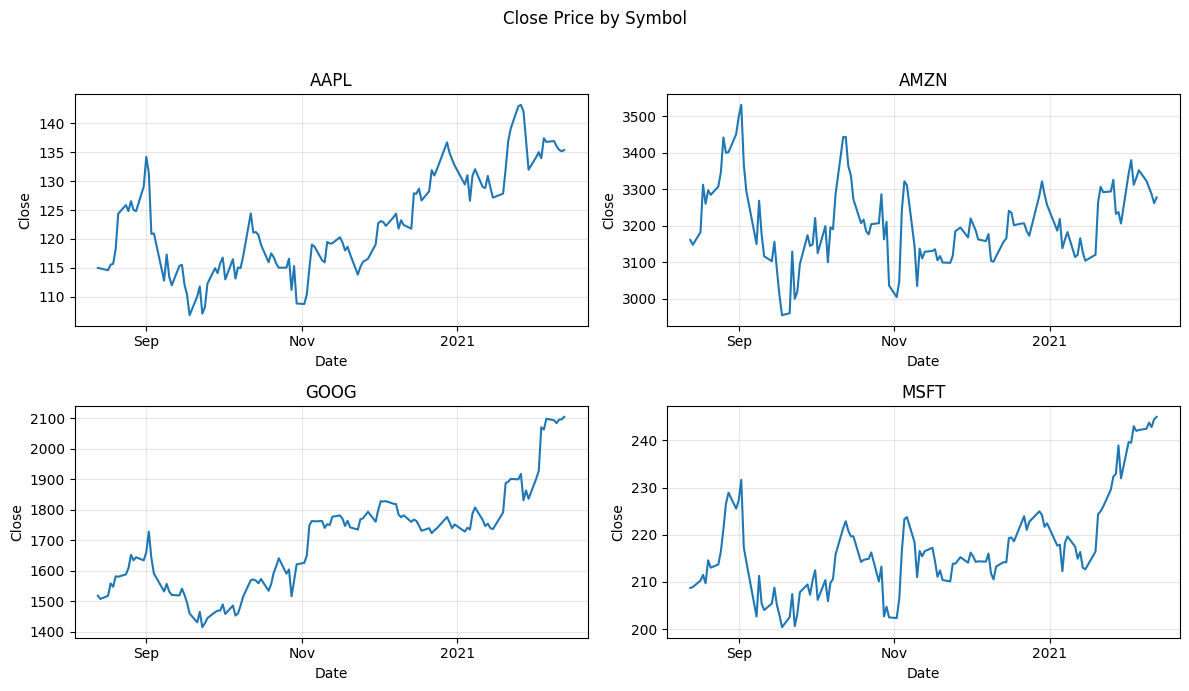

In [3]:
def plot_close_composite(
    df: pd.DataFrame,
    *,
    symbol_col: str = "Symbol",
    date_col: str = "Date",
    close_col: str = "Close/Last",
    ncols: int = 2,
    figsize_per_ax: Tuple[float, float] = (6.0, 3.5),
    title: Optional[str] = None,
    date_locator: Optional[mdates.DateLocator] = None,
    date_formatter: Optional[mdates.DateFormatter] = None,
) -> Tuple[plt.Figure, np.ndarray]:
    """Plot a 2-column composite of close-price line charts, one per symbol.

    Parameters
    ----------
    df:
        Input DataFrame.
    symbol_col, date_col, close_col:
        Column names in df.
    ncols:
        Number of columns in the composite (2 required by the task, but configurable).
    figsize_per_ax:
        Approx (width, height) per subplot; overall figure size scales with grid size.
    title:
        Optional suptitle.

    Returns
    -------
    (fig, axes)
        Matplotlib Figure and axes array.
    """
    if ncols <= 0:
        raise ValueError("ncols must be a positive integer")

    required = {symbol_col, date_col, close_col}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"DataFrame missing columns: {sorted(missing)}")

    work = df[[symbol_col, date_col, close_col]].copy()
    work[date_col] = pd.to_datetime(work[date_col], errors="coerce")
    work[close_col] = pd.to_numeric(work[close_col], errors="coerce")
    work = work.dropna(subset=[date_col, close_col])

    symbols = work[symbol_col].dropna().astype("string").unique().tolist()
    if not symbols:
        raise ValueError("No symbols found to plot.")

    n = len(symbols)
    nrows = ceil(n / ncols)
    fig_w = figsize_per_ax[0] * ncols
    fig_h = figsize_per_ax[1] * nrows
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(fig_w, fig_h), squeeze=False
    )

    # Date formatting defaults
    if date_locator is None:
        date_locator = mdates.AutoDateLocator(minticks=3, maxticks=6)
    if date_formatter is None:
        date_formatter = mdates.ConciseDateFormatter(date_locator)

    for i, sym in enumerate(symbols):
        ax = axes[i // ncols, i % ncols]
        sub = work.loc[work[symbol_col] == sym].sort_values(date_col)
        ax.plot(sub[date_col], sub[close_col], label="Close")
        ax.set_title(str(sym))
        ax.set_xlabel("Date")
        ax.set_ylabel("Close")
        ax.xaxis.set_major_locator(date_locator)
        ax.xaxis.set_major_formatter(date_formatter)
        ax.grid(True, alpha=0.3)

    # Turn off any extra axes
    for j in range(n, nrows * ncols):
        axes[j // ncols, j % ncols].axis("off")

    if title:
        fig.suptitle(title)
        fig.tight_layout(rect=(0, 0, 1, 0.96))
    else:
        fig.tight_layout()

    return fig, axes


fig, axes = plot_close_composite(quotes, ncols=2, title="Close Price by Symbol")
plt.show()

## Question 2 solution

Expand the previous function to include an `n`-day moving average on each chart.

**Important:** Moving averages must be computed after sorting each symbol's data by date.

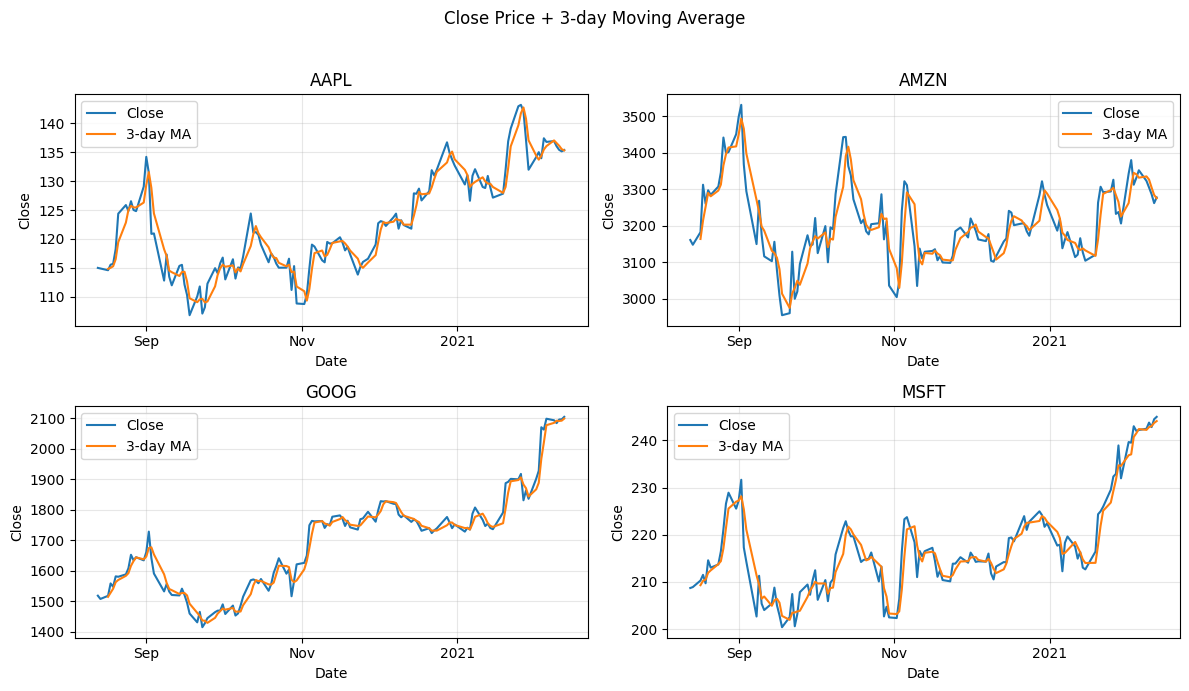

In [4]:
def plot_close_with_moving_average(
    df: pd.DataFrame,
    *,
    n: int = 5,
    min_periods: Optional[int] = None,
    symbol_col: str = "Symbol",
    date_col: str = "Date",
    close_col: str = "Close/Last",
    ncols: int = 2,
    figsize_per_ax: Tuple[float, float] = (6.0, 3.5),
    title: Optional[str] = None,
) -> Tuple[plt.Figure, np.ndarray]:
    """Plot close price and an n-day moving average in a 2-column composite.

    Parameters
    ----------
    n:
        Window size for the moving average.
    min_periods:
        Minimum periods for rolling mean; defaults to n (full window).
    """
    if n <= 0:
        raise ValueError("n must be a positive integer")
    if min_periods is None:
        min_periods = n
    if min_periods <= 0:
        raise ValueError("min_periods must be a positive integer")

    required = {symbol_col, date_col, close_col}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"DataFrame missing columns: {sorted(missing)}")

    work = df[[symbol_col, date_col, close_col]].copy()
    work[date_col] = pd.to_datetime(work[date_col], errors="coerce")
    work[close_col] = pd.to_numeric(work[close_col], errors="coerce")
    work = work.dropna(subset=[date_col, close_col])

    symbols = work[symbol_col].dropna().astype("string").unique().tolist()
    if not symbols:
        raise ValueError("No symbols found to plot.")

    n_syms = len(symbols)
    nrows = ceil(n_syms / ncols)
    fig_w = figsize_per_ax[0] * ncols
    fig_h = figsize_per_ax[1] * nrows
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(fig_w, fig_h), squeeze=False
    )

    locator = mdates.AutoDateLocator(minticks=3, maxticks=6)
    formatter = mdates.ConciseDateFormatter(locator)

    for i, sym in enumerate(symbols):
        ax = axes[i // ncols, i % ncols]
        sub = work.loc[work[symbol_col] == sym].sort_values(date_col)

        # Moving average computed in time order
        ma = sub[close_col].rolling(window=n, min_periods=min_periods).mean()

        ax.plot(sub[date_col], sub[close_col], label="Close")
        ax.plot(sub[date_col], ma, label=f"{n}-day MA")

        ax.set_title(str(sym))
        ax.set_xlabel("Date")
        ax.set_ylabel("Close")
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.grid(True, alpha=0.3)
        ax.legend(loc="best")

    for j in range(n_syms, nrows * ncols):
        axes[j // ncols, j % ncols].axis("off")

    if title is None:
        title = f"Close Price + {n}-day Moving Average"
    fig.suptitle(title)
    fig.tight_layout(rect=(0, 0, 1, 0.96))
    return fig, axes


fig, axes = plot_close_with_moving_average(quotes, n=3)
plt.show()

## Question 3 solution

Add horizontal lines for the 25th, 50th, and 75th percentiles of the close price.

Interpretation used here: percentiles are computed **per symbol** over the entire time period available for that symbol.

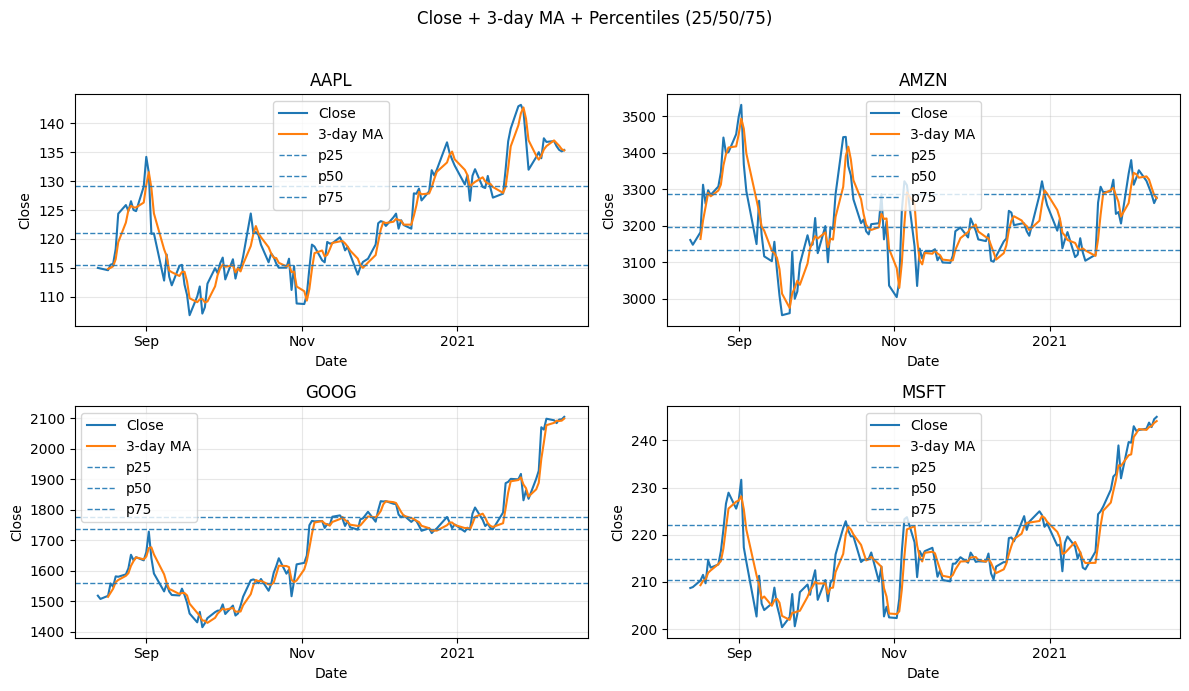

In [5]:
def plot_close_ma_with_percentiles(
    df: pd.DataFrame,
    *,
    n: int = 5,
    min_periods: Optional[int] = None,
    percentiles: Sequence[float] = (0.25, 0.50, 0.75),
    symbol_col: str = "Symbol",
    date_col: str = "Date",
    close_col: str = "Close/Last",
    ncols: int = 2,
    figsize_per_ax: Tuple[float, float] = (6.0, 3.5),
    title: Optional[str] = None,
) -> Tuple[plt.Figure, np.ndarray]:
    """Plot close price + moving average + percentile lines in a 2-column composite."""
    if n <= 0:
        raise ValueError("n must be a positive integer")
    if min_periods is None:
        min_periods = n
    if any((p <= 0 or p >= 1) for p in percentiles):
        raise ValueError("percentiles must be in (0, 1), e.g. 0.25, 0.5, 0.75")

    required = {symbol_col, date_col, close_col}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"DataFrame missing columns: {sorted(missing)}")

    work = df[[symbol_col, date_col, close_col]].copy()
    work[date_col] = pd.to_datetime(work[date_col], errors="coerce")
    work[close_col] = pd.to_numeric(work[close_col], errors="coerce")
    work = work.dropna(subset=[date_col, close_col])

    symbols = work[symbol_col].dropna().astype("string").unique().tolist()
    if not symbols:
        raise ValueError("No symbols found to plot.")

    n_syms = len(symbols)
    nrows = ceil(n_syms / ncols)
    fig_w = figsize_per_ax[0] * ncols
    fig_h = figsize_per_ax[1] * nrows
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(fig_w, fig_h), squeeze=False
    )

    locator = mdates.AutoDateLocator(minticks=3, maxticks=6)
    formatter = mdates.ConciseDateFormatter(locator)

    for i, sym in enumerate(symbols):
        ax = axes[i // ncols, i % ncols]
        sub = work.loc[work[symbol_col] == sym].sort_values(date_col)

        close = sub[close_col]
        ma = close.rolling(window=n, min_periods=min_periods).mean()

        ax.plot(sub[date_col], close, label="Close")
        ax.plot(sub[date_col], ma, label=f"{n}-day MA")

        # Percentiles over the entire available history for this symbol
        q_values = close.quantile(list(percentiles))
        for p, val in q_values.items():
            ax.axhline(
                val,
                linestyle="--",
                linewidth=1.0,
                alpha=0.9,
                label=f"p{int(round(p * 100))}",
            )

        ax.set_title(str(sym))
        ax.set_xlabel("Date")
        ax.set_ylabel("Close")
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        ax.grid(True, alpha=0.3)

        # De-duplicate legend entries (Close/MA + percentile labels)
        handles, labels = ax.get_legend_handles_labels()
        unique = {}
        for h, lab in zip(handles, labels):
            if lab not in unique:
                unique[lab] = h
        ax.legend(unique.values(), unique.keys(), loc="best")

    for j in range(n_syms, nrows * ncols):
        axes[j // ncols, j % ncols].axis("off")

    if title is None:
        title = f"Close + {n}-day MA + Percentiles (25/50/75)"
    fig.suptitle(title)
    fig.tight_layout(rect=(0, 0, 1, 0.96))
    return fig, axes


fig, axes = plot_close_ma_with_percentiles(quotes, n=3)
plt.show()